In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi
import os
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
from PIL import Image
import urllib, cStringIO
import cv2

In [2]:
BATCH_SIZE = 32


In [3]:
attr_file = '../data/celeba/list_attr_celeba.txt'
keys = None
attributes_by_image = {}
for i, line in enumerate(open(attr_file)):
    if i == 1:
        keys = line.split()
    elif i > 1:
        image = os.path.join('../data/celeba/img_align_celeba', line.split()[0])
        values = line.split()[1:]
        attributes_by_image[image] = {attr: val == '1' for attr, val in zip(keys, values)}


In [4]:
image_names = attributes_by_image.keys()
attr_vector = np.zeros((len(attributes_by_image), len(keys)))
for i, image_name in enumerate(image_names):
    attrs = attributes_by_image[image_name]
    attr_vector[i] = [(1 if attrs[key] else 0) for key in keys]


In [5]:
# filename_queue = tf.train.string_input_producer(image_names, num_epochs=None)
# attr_queue = tf.train.input_producer(tf.constant(attr_vector), num_epochs=None)

def create_qs(train):
    filename_tensor = tf.convert_to_tensor(image_names, dtype=tf.string)
    attr_tensor = tf.convert_to_tensor(attr_vector, dtype=tf.float32)
    filename_q, attr_q = tf.train.slice_input_producer([filename_tensor, attr_tensor], num_epochs=None, shuffle=True)

    # reader = tf.WholeFileReader()
    # filename, image_data = reader.read(filename_q)
    image_255 = tf.image.decode_jpeg(tf.read_file(filename_q))
    image = tf.reshape(tf.cast(image_255, tf.float32) / 255.0, [218, 178, 3]) # images are 178x218
    image = tf.image.rgb_to_grayscale(image)

    def resize_image(image):
        # image = tf.random_crop(image, [192, 160, 3])
        # return image
        image = tf.image.resize_image_with_crop_or_pad(image, 160, 160)
        img_reshaped = tf.reshape(image, [1, 160, 160, 1])
        image = tf.image.resize_bilinear(img_reshaped, [64, 64])
        return tf.reshape(image, [64, 64, 1])
    image = resize_image(image)

    def distort_image(image):
        # noise_amt = tf.abs(tf.random_normal([], stddev=0.2))
        # distorted_image = image + tf.random_uniform([64, 64, 3], maxval=noise_amt)
        distorted_image = tf.image.random_flip_left_right(image)
        distorted_image = tf.image.random_brightness(distorted_image, max_delta=0.3)
        distorted_image = tf.image.random_contrast(distorted_image, lower=0.6, upper=1.6)
        # distorted_image = tf.image.per_image_standardization(distorted_image)
        # distorted_image = tf.clip_by_value(distorted_image, 0, 1)
        return distorted_image

    images_batch, attrs_batch = tf.train.shuffle_batch([distort_image(image), attr_q], batch_size=BATCH_SIZE, capacity=BATCH_SIZE*20, min_after_dequeue=BATCH_SIZE*10)
    return images_batch, attrs_batch

images_batch, attrs_batch = create_qs(True)


In [6]:
session = tf.InteractiveSession()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
tf.train.start_queue_runners(sess=session)

[<Thread(Thread-13, started daemon 140305935501056)>,
 <Thread(Thread-14, started daemon 140305927108352)>]

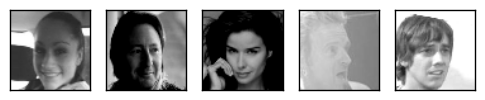

In [7]:
%matplotlib inline

images_, attrs_ = session.run([tf.image.grayscale_to_rgb(images_batch), attrs_batch])

imshow_multi(images_[:5])

In [8]:
keys

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [9]:
dropout_keep_prob = tf.placeholder_with_default(tf.constant(1.0), [], name='dropout_keep_prob')        

def lrelu(x):
    alpha = 0.2
    return tf.maximum(alpha*x, x)

relu = tf.nn.relu

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape())-1
    return tf.nn.elu(tf.concat(axis, [x, -x]))

def concat_lrelu(x):
    axis = len(x.get_shape())-1
    return lrelu(tf.concat(axis, [x, -x]))

def concat_relu(x):
    axis = len(x.get_shape())-1
    return tf.nn.relu(tf.concat(axis, [x, -x]))

def create_batch_norm(inputs, name='bn'):
    with tf.variable_scope(name):
        return batch_norm(inputs, is_training=True, updates_collections=None)

def create_dropout(inputs):
    return tf.nn.dropout(inputs, dropout_keep_prob)

# conv_init =  lambda shape, dtype, partition_info: np.random.rand(*shape) * 0.1
# zero_init = lambda shape, dtype, partition_info: np.random.rand(*shape) * 0

def create_max_pool(inputs, ksize=2, stride=2):
    return tf.nn.max_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_avg_pool(inputs, ksize=2, stride=2):
    return tf.nn.avg_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

bias_init = tf.truncated_normal_initializer(0.1, 0.0)

def create_conv(input, out_channels, patch_size=5, stride=1, name='conv'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        # w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w', key=join_keys(key, 'w'))
        # b = weight_var([out_channels], stddev=0, name='b', mean=0.1, key=join_keys(key, 'b'))
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, in_channels, out_channels], 
                            initializer=xavier_initializer())
        b = tf.get_variable('b',
                           shape=[out_channels],
                           initializer=bias_init)
        conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
        return conv+b

def create_deconv(input, out_channels, patch_size=5, stride=1, name='deconv'):
    with tf.variable_scope(name):
        # for best results, patch_size should be a multiple of stride
        input_w, input_h, input_channels = [i.value for i in input.get_shape()[-3:]]

        # w = weight_var([patch_size, patch_size, out_channels, input_channels])
        # b = weight_var([out_channels], mean=0.1)
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, out_channels, input_channels], 
                            initializer=xavier_initializer())
        b = tf.get_variable('b',
                            shape=[out_channels],
                            initializer=bias_init)

        batch_size = BATCH_SIZE # tf.shape(input)[0]
        output_shape = tf.pack([batch_size, input_w*stride, input_h*stride, out_channels])

        deconv = tf.nn.conv2d_transpose(input, w, output_shape, strides=[1,stride,stride,1], padding='SAME')

        return deconv + b

def create_fc(input, out_channels, name='fc'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        w = tf.get_variable('w', shape=[in_channels, out_channels], initializer=xavier_initializer())
        b = tf.get_variable('b', shape=[out_channels], initializer=bias_init)
        return tf.matmul(input, w) + b

def create_inter_minibatch_layer(input, channels_to_add=4, name='ib1'):
    with tf.variable_scope(name):
        count = input.get_shape()[0].value
        offset_batch = tf.concat(0, [input[1:count], input[0:1]])
        diff = input - offset_batch
        filtered = create_conv(diff, channels_to_add, patch_size=1)
        return tf.concat(len(input.get_shape())-1, [input, filtered])
    

In [10]:

def generator(noise_vec, condition_vec, name='gen', reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        # output size must be 64
        vec = tf.concat(1, [noise_vec, tf.cast(condition_vec, tf.float32)])
        vec = create_fc(vec, 512, name='fc1')
        image = tf.reshape(vec, [-1, 2, 2, 128])
        layers = [64, 64, 32, 32, 1]
        for i, channels in enumerate(layers):
                _,w,h,_ = image.get_shape()
                image = tf.image.resize_bilinear(image, [w.value*2, h.value*2])
                image = create_conv(image, channels, patch_size=3, stride=1, name='resize_conv'+str(i))
                if i+1 < len(layers):
                    image = tf.nn.relu(image)
                    image = create_batch_norm(image, name='bn'+str(i))
        return tf.nn.sigmoid(image)

def discriminator_and_classifier(image, condition_vec_size, name='disc', reuse=False):
    with tf.variable_scope(name, reuse):
        layers = [32, 32, 64, 64, 128]
        for i, channels in enumerate(layers):
            image = create_conv(image, channels, patch_size=3, stride=1, name='conv'+str(i))
            image = create_avg_pool(image)
            image = lrelu(image)
            image = create_batch_norm(image, name='bn'+str(i))
            if i+1 < len(layers):
                image = create_dropout(image)
                image = create_inter_minibatch_layer(image, name='ib'+str(i))
        # image is now 2x2x128
        vec = tf.reshape(image, [-1, 2 * 2 * 128])
        is_real = create_fc(vec, 2, name='fc1')
        cond_vec = tf.reshape(create_fc(vec, condition_vec_size * 2, name='fc2'), [-1, condition_vec_size, 2])
        return is_real, cond_vec

def compute_loss(logits, targets):
    # takes in logits with last dimension = 2, and targets that are 0 or 1
    targets = tf.cast(targets, tf.int32)
    targets = tf.one_hot(targets, depth=2, on_value=0.9)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, targets))
    
def compute_accuracy(logits, target):
    argmax = tf.argmax(logits, axis=len(logits.get_shape())-1)
    argmax = tf.cast(argmax, tf.int32)
    correct = tf.equal(argmax, target)
    return tf.reduce_mean(tf.cast(correct, tf.float32))

scopename = 'acgan4'
with tf.variable_scope(scopename, reuse=False):
    disc_lr = tf.placeholder_with_default(tf.constant(0.0002), [], name='disc_lr')
    gen_lr = tf.placeholder_with_default(tf.constant(0.0004), [], name='gen_lr')
    
    attributes = ['Male', 'Smiling']
    attr_indices = [keys.index(attr) for attr in attributes]
    real_cond_vec = tf.transpose(tf.gather(tf.transpose(attrs_batch, [1, 0]), attr_indices), [1, 0])
    real_cond_vec = tf.cast(real_cond_vec, tf.int32)
    
    fake_cond_vec = tf.random_uniform([BATCH_SIZE, len(attributes)], minval=0, maxval=2, dtype=tf.int32)
    noise = tf.random_uniform([BATCH_SIZE, 32], minval=-1, maxval=1)
    generated_images = generator(noise, fake_cond_vec)
    
    disc_input = tf.concat(0, [generated_images, images_batch])
    is_real, pred_cond = discriminator_and_classifier(disc_input, len(attributes))
    gen_cond_pred = pred_cond[:BATCH_SIZE]
    
    is_real_target = tf.cast(tf.concat(0, [tf.zeros([BATCH_SIZE]), tf.ones([BATCH_SIZE])]), tf.int32)
    pred_target = tf.concat(0, [fake_cond_vec, real_cond_vec]) # [128, 2]
    
    disc_loss = compute_loss(is_real, is_real_target) / len(attributes)
    # discriminator loss should have the same weight as a single attribute
    disc_acc = compute_accuracy(is_real, is_real_target)
    
    classifier_loss = 0 # compute_loss(pred_cond, pred_target)
    classifier_acc = compute_accuracy(pred_cond, pred_target)
    
    cond_loss = 0 # compute_loss(gen_cond_pred, fake_cond_vec)
    
    global_step = tf.contrib.framework.get_or_create_global_step()
    
    disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/disc')
    train_disc = tf.train.AdamOptimizer(disc_lr, beta1=0.5).minimize(classifier_loss+disc_loss, global_step=global_step, var_list=disc_vars)
    
    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/gen')
    train_gen = tf.train.AdamOptimizer(gen_lr, beta1=0.5).minimize(classifier_loss-disc_loss+cond_loss, global_step=global_step, var_list=gen_vars)
    
    examples = tf.image.grayscale_to_rgb(generated_images)


In [11]:
save_path = None # 'models/acgan2-3'

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)

import os
saver = None
if save_path:
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(save_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(session, ckpt.model_checkpoint_path)
        print 'Restored from checkpoint', ckpt.model_checkpoint_path
    else:
        print 'Did not restore from checkpoint'
else:
    print 'Will not save progress'



Will not save progress


Step: 10,  disc accuracy: 0.6328125, class accuracy: 0.475
Step: 20,  disc accuracy: 0.6609375, class accuracy: 0.50546875
Step: 30,  disc accuracy: 0.61875, class accuracy: 0.50078125
Step: 40,  disc accuracy: 0.7640625, class accuracy: 0.4984375
Step: 50,  disc accuracy: 0.7015625, class accuracy: 0.50234375


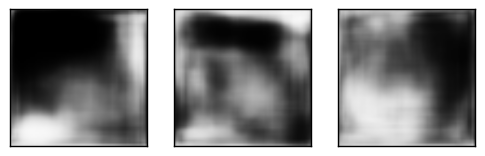

Step: 60,  disc accuracy: 0.68125, class accuracy: 0.50625
Step: 70,  disc accuracy: 0.715625, class accuracy: 0.49765625
Step: 80,  disc accuracy: 0.7359375, class accuracy: 0.49609375
Step: 90,  disc accuracy: 0.721875, class accuracy: 0.49609375
Step: 100,  disc accuracy: 0.778409090909, class accuracy: 0.493607954545


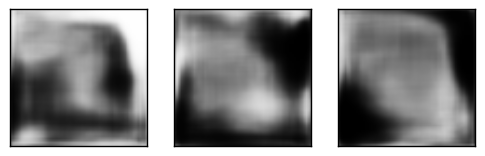

Step: 110,  disc accuracy: 0.753472222222, class accuracy: 0.504340277778
Step: 120,  disc accuracy: 0.825, class accuracy: 0.515625
Step: 130,  disc accuracy: 0.7734375, class accuracy: 0.50625
Step: 140,  disc accuracy: 0.8234375, class accuracy: 0.496875
Step: 150,  disc accuracy: 0.6640625, class accuracy: 0.515625


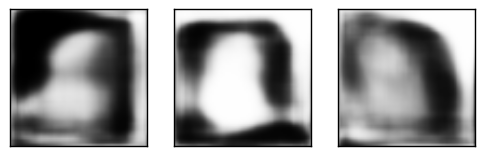

Step: 160,  disc accuracy: 0.7515625, class accuracy: 0.48203125
Step: 170,  disc accuracy: 0.741477272727, class accuracy: 0.489346590909
Step: 180,  disc accuracy: 0.685763888889, class accuracy: 0.513020833333
Step: 190,  disc accuracy: 0.764204545455, class accuracy: 0.485085227273
Step: 200,  disc accuracy: 0.753125, class accuracy: 0.5015625


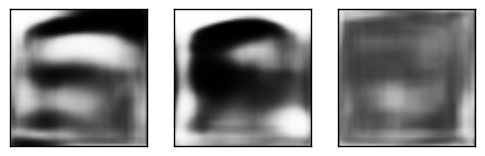

Step: 210,  disc accuracy: 0.7609375, class accuracy: 0.5015625
Step: 220,  disc accuracy: 0.7328125, class accuracy: 0.51171875
Step: 230,  disc accuracy: 0.815972222222, class accuracy: 0.497395833333
Step: 240,  disc accuracy: 0.8890625, class accuracy: 0.4953125
Step: 250,  disc accuracy: 0.96875, class accuracy: 0.5078125


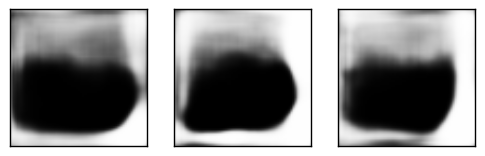

Step: 260,  disc accuracy: 0.965625, class accuracy: 0.51015625
Step: 270,  disc accuracy: 0.965625, class accuracy: 0.48046875
Step: 280,  disc accuracy: 0.96875, class accuracy: 0.48671875
Step: 290,  disc accuracy: 0.96875, class accuracy: 0.47890625
Step: 300,  disc accuracy: 0.9671875, class accuracy: 0.4890625


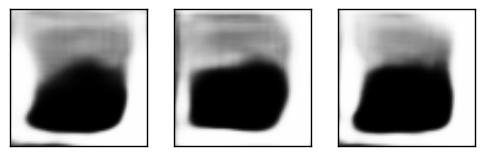

Step: 310,  disc accuracy: 0.965625, class accuracy: 0.45078125


KeyboardInterrupt: 

In [12]:
%matplotlib inline

def avg(x): return sum(x) / float(len(x))
disc_accuracies = []
class_accuracies = []

last_step_printed = -1

while True:
    examples_ = None
            
    if not (len(disc_accuracies) and avg(disc_accuracies) < 0.5):
        # train gen:
        examples_, disc_acc_, class_acc_, step_, _ = session.run(
            [examples[:3], disc_acc, classifier_acc, global_step, train_gen],
            feed_dict={})
        disc_accuracies.append(disc_acc_)
        class_accuracies.append(class_acc_)
    
    if len(disc_accuracies) and avg(disc_accuracies) < 0.8:
        # train disc:
        feed = {dropout_keep_prob: 0.5}
        examples_, disc_acc_, class_acc_, step_, _ = session.run(
            [examples[:3], disc_acc, classifier_acc, global_step, train_disc], feed_dict=feed)
        disc_accuracies.append(disc_acc_)
        class_accuracies.append(class_acc_)
    
    step_rounded = int(step_ / 2) * 2
    if step_rounded % 10 == 0 and step_rounded != last_step_printed:
        last_step_printed = step_rounded
            
        print "Step: {},  disc accuracy: {}, class accuracy: {}".format(step_rounded, avg(disc_accuracies), avg(class_accuracies))
        
        if step_rounded % 50 == 0 and examples_ is not None:
            imshow_multi(list(examples_[:3]))
        
        if step_rounded % 150 == 0 and saver:
            should_save = True
            if should_save:
                saver.save(session, save_path + '/model.ckpt', global_step=step_rounded)
                print 'Saved'
            else:
                pass
                # print 'Loss did not decrease from previous save, so not saving'
        
        disc_accuracies = []
        class_accuracies = []


In [ ]:
# debug:

fake_cond_vec_, real_cond_vec_, _ = session.run([fake_cond_vec, real_cond_vec, images_batch])
print fake_cond_vec_
print real_cond_vec_